In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
# CNN MNIST MODEL

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform and load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Adjust based on output shape
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Dynamically compute the size
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model, define loss and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
for epoch in range(5):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} complete. Loss: {loss.item()}")

# Evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1 complete. Loss: 0.01537106279283762
Epoch 2 complete. Loss: 0.053443219512701035
Epoch 3 complete. Loss: 0.005533848889172077
Epoch 4 complete. Loss: 0.005277304910123348
Epoch 5 complete. Loss: 0.0027428101748228073
Test Accuracy: 99.08%


In [10]:
# Generate Adversarial Images

Original labels: [4 4 4 4 4 4 4 4 4 4]
Adversarial predictions: [9 9 9 9 9 9 9 9 9 9]


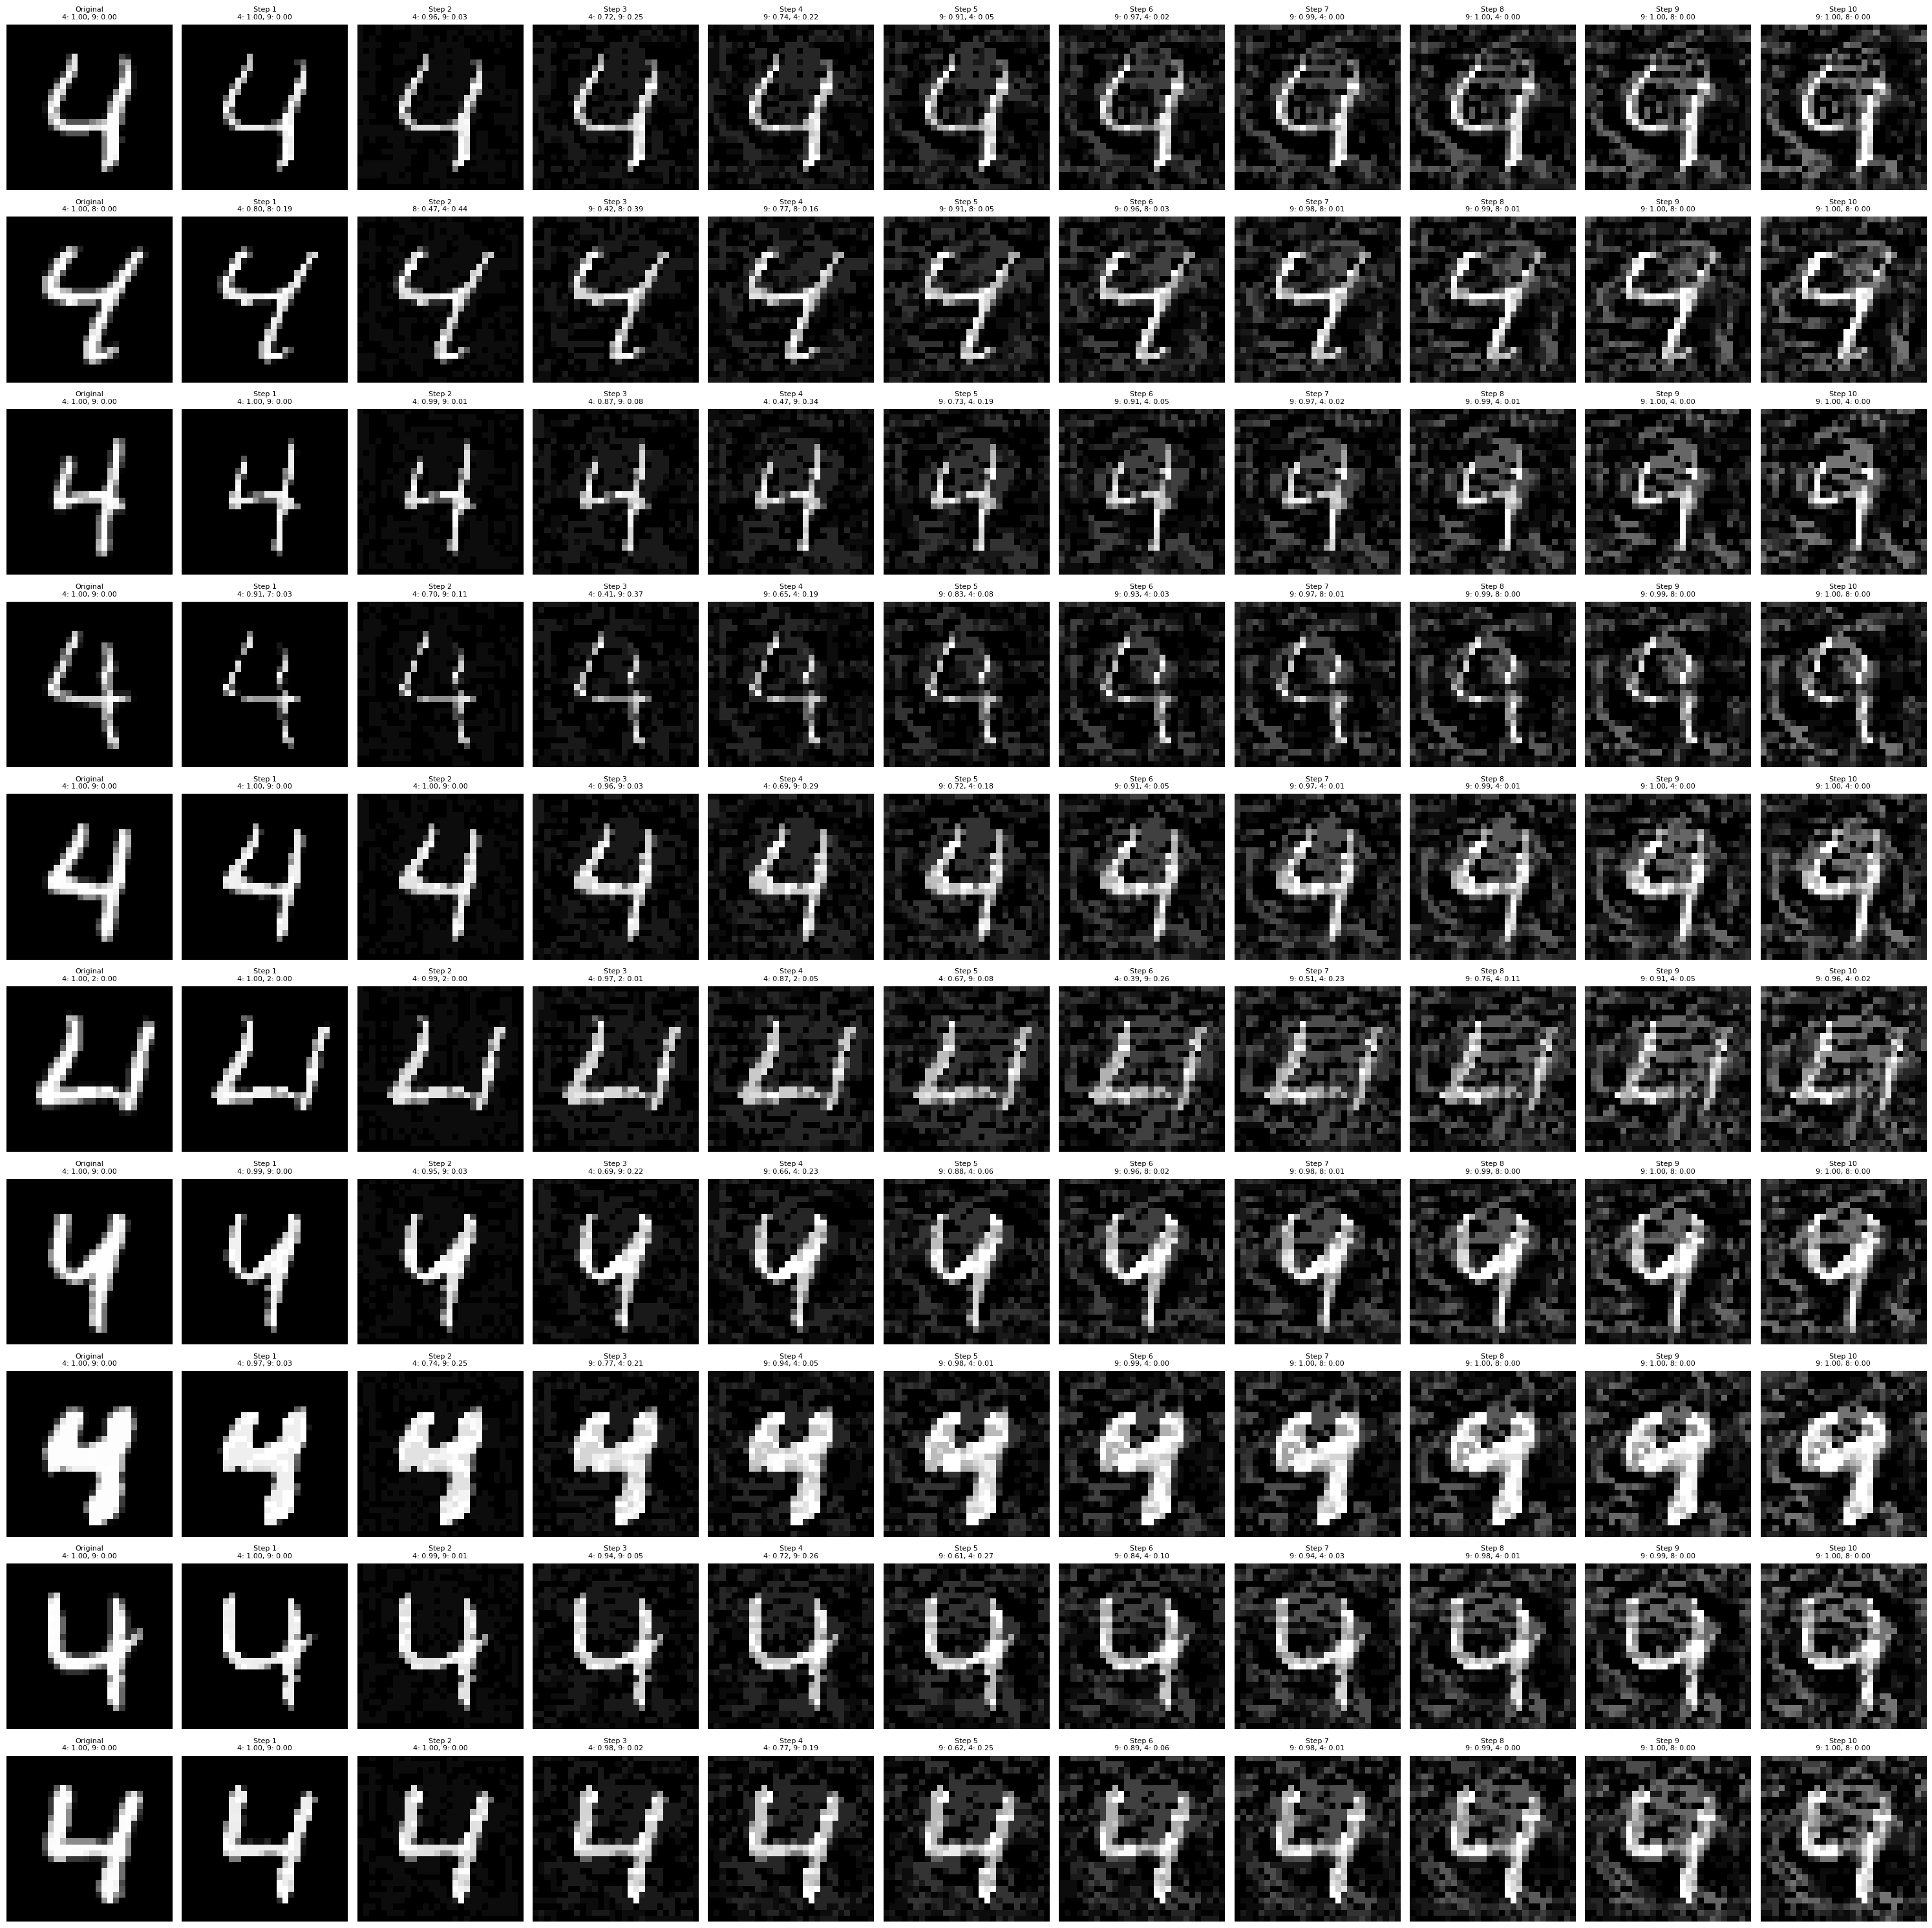

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def targeted_fgsm_attack(model, image, target_label, alpha, num_steps):

    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True

    # Store adversarial images at each step
    adv_steps_list = [perturbed_image.clone().detach()]

    for _ in range(num_steps):
        # Forward pass
        output = model(perturbed_image)
        loss = F.cross_entropy(output, target_label)

        # Compute gradients
        model.zero_grad()
        loss.backward()

        # Generate perturbation
        grad = -perturbed_image.grad.data.sign()  # Negate gradient for targeted attack
        perturbed_image = perturbed_image + alpha * grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1).detach()  # Keep within valid range
        perturbed_image.requires_grad = True

        # Append current perturbed image to the list of adversarial images
        adv_steps_list.append(perturbed_image.clone().detach())

    return adv_steps_list

# Select samples of "4"
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    # Only consider images with label "4"
    mask = labels == 4
    if not mask.any():
        continue  # Skip batches with no "4"
    
    images, labels = images[mask], labels[mask]
    break  # Use a small batch for demonstration

# Define the target label (e.g., "9")
target_label = torch.full_like(labels, 9)

# Generate adversarial images
alpha = 0.05  # Step size for each iteration
num_steps = 10  # Number of iterations

adv_steps_list = targeted_fgsm_attack(model, images, target_label, alpha, num_steps)

# Verify adversarial success
outputs = model(adv_steps_list[-1])
_, predicted = torch.max(outputs, 1)
print(f"Original labels: {labels.cpu().detach().numpy()}")
print(f"Adversarial predictions: {predicted.cpu().detach().numpy()}")

def plot_adversarial_matrix(model, adv_steps_list, labels_true, labels_target, step_count=3):
    """
    Visualize the original and adversarial images at each step along with the predicted class probabilities.
    """
    model.eval()
    class_names = [str(i) for i in range(10)]  # Class labels from 0 to 9
    fig, axes = plt.subplots(10, step_count + 1, figsize=(step_count * 3, 30))

    for step in range(step_count + 1):
        step_images = adv_steps_list[step]
        with torch.no_grad():
            # Get predicted probabilities for each class
            probs = F.softmax(model(step_images), dim=1).cpu().numpy()
        
            for i in range(len(step_images)):
                img = step_images[i].cpu().squeeze()
                
                # Find the top 2 predicted classes and their probabilities
                top_probs, top_classes = torch.topk(torch.tensor(probs[i]), 2)
                
                # Convert top predictions to human-readable format
                top_probs = top_probs.numpy()
                top_classes = top_classes.numpy()

                # Setup the axis for the current image
                ax = axes[i, step]
                ax.imshow(img, cmap='gray')
                ax.axis('off')

                # Display titles with top predictions and probabilities
                if step == 0:
                    ax.set_title(f"Original\n{class_names[top_classes[0]]}: {top_probs[0]:.2f}, {class_names[top_classes[1]]}: {top_probs[1]:.2f}", fontsize=8)
                else:
                    ax.set_title(f"Step {step}\n{class_names[top_classes[0]]}: {top_probs[0]:.2f}, {class_names[top_classes[1]]}: {top_probs[1]:.2f}", fontsize=8)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_adversarial_matrix(model, adv_steps_list, labels, target_label, step_count=10)